# Diabetes experiment

In [1]:
import pandas as pd
import numpy as np
import statistics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
import sys
sys.path.append('../../')
from src.elm.elms import ClassicELM, ToeplitzELM, CirculantELM, FastFoodELM, ToeplitzLikeELM, VandermondeELM, LowRankELM
import hpelm
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.initializers import RandomNormal

# Preprocessing

In [2]:
# Load data
diabetes_dataset = pd.read_csv("../datasets/diabetes.csv")
y = diabetes_dataset.Outcome
# y = np.expand_dims(y, -1)
y[y == 0] = -1

x = diabetes_dataset.drop("Outcome", axis=1)

/Users/russii/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [3]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, 
                                                            shuffle=True, random_state=42, stratify=y)
y_train_hp = np.expand_dims(y_train, -1)
y_test_hp = np.expand_dims(y_test, -1)

In [4]:
print(f"Percentage of negative result is {y[y==-1].shape[0] / y.shape[0]}")

Percentage of negative result is 0.6510416666666666


In [5]:
# Scale
scaler = StandardScaler(copy=False, with_mean=True, with_std=True)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [6]:
x=None
y=None
scaler=None
diabetes_dataset=None

# Train method

In [7]:
def test(elm_class, neurons_number=20, use_bias=True, trial_number=50, print_every=10,
                  kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform",
                 regression_tool="ridge_sklearn", alpha=1e-9, **kwargs):
    training_score = []
    testing_score = []
    
    stddev = 1 / (x_train[0].shape[0] ** 0.5)
    for i in range(trial_number):
        elm = elm_class(hidden_neurons=[neurons_number], is_classifier=True, activation="sigmoid", input_shape=x_train[0].shape, use_bias=True,
                     kernel_initializer=RandomNormal(0, stddev), bias_initializer=RandomNormal(0, 1), dev=stddev, **kwargs)
        elm.fit(x_train, y_train, regression_tool=regression_tool, alpha=alpha)
        training_score.append(elm.calculate_classification_accuracy(x_train, y_train))
        testing_score.append(elm.calculate_classification_accuracy(x_test, y_test))
        if (i + 1) % print_every == 0:
            print(f"{i + 1}/{trial_number} Training score: {training_score[i]:.{4}}. "
                  f"Testing score: {testing_score[i]:.{4}}")
    return [training_score, testing_score]

def test_hpelm(neurons_number=50, trial_number=50, print_every=10):
    hpelm_training_rmse = []
    hpelm_testing_rmse = []
    for i in range(trial_number):
        elm = hpelm.ELM(x_train.shape[1], y_train_hp.shape[1])
        elm.add_neurons(neurons_number, "sigm")
        elm.train(x_train, y_train_hp)
        hpelm_training_rmse.append(accuracy_score(y_train_hp > 0, elm.predict(x_train) > 0))
        hpelm_testing_rmse.append(accuracy_score(y_test_hp > 0, elm.predict(x_test) > 0))
        if(i + 1) % print_every == 0:
            print(f"{i + 1}/{trial_number} Training RMSE: {hpelm_training_rmse[i]:.{4}}. Testing RMSE: {hpelm_testing_rmse[i]:.{4}}")
    return [hpelm_training_rmse, hpelm_testing_rmse]       
    

def print_result(name, training_score, testing_score):
    print(name)
    print(f"Training Score: {statistics.mean(training_score):.{4}}")
    print(f"Testing Score: {statistics.mean(testing_score):.{4}}")

# Train the best ELMs
### Execution will take much time!

In [8]:
classical_scores = []
t_scores = []
c_scores = []
hpelm_scores = []

fastfood_scores = []
low_rank = []

neurons = []

In [18]:
for i in range(2, 15):
    n = i * 2
    neurons.append(n)
    
    print(f"Neurons: {n}")
    
    print("Hpelm")
    hpelm_scores.append(test_hpelm(neurons_number=n))
    
    print("My classical ELM")
    classical_scores.append(test(ClassicELM, neurons_number=n))
    
    print("Toeplitz ELM")
    t_scores.append(test(ToeplitzELM, neurons_number=n))

    print("Ciculant ELM")
    c_scores.append(test(CirculantELM, neurons_number=n))
    
    print("Fastfood ELM")
    fastfood_scores.append(test(FastFoodELM, neurons_number=n))
    
    print("LowRank ELM")
    low_rank.append(test(ToeplitzLikeELM, neurons_number=n))

Neurons: 22
Hpelm
10/50 Training RMSE: 0.783. Testing RMSE: 0.7135
20/50 Training RMSE: 0.783. Testing RMSE: 0.7292
30/50 Training RMSE: 0.7795. Testing RMSE: 0.7292
40/50 Training RMSE: 0.7917. Testing RMSE: 0.7135
50/50 Training RMSE: 0.7951. Testing RMSE: 0.7083
My classical ELM
10/50 Training score: 0.8021. Testing score: 0.7292
20/50 Training score: 0.7899. Testing score: 0.7604
30/50 Training score: 0.7969. Testing score: 0.724
40/50 Training score: 0.7882. Testing score: 0.75
50/50 Training score: 0.7986. Testing score: 0.7396
Toeplitz ELM
10/50 Training score: 0.7882. Testing score: 0.7604
20/50 Training score: 0.7899. Testing score: 0.7448
30/50 Training score: 0.7899. Testing score: 0.7292
40/50 Training score: 0.7986. Testing score: 0.7396
50/50 Training score: 0.7951. Testing score: 0.724
Ciculant ELM
10/50 Training score: 0.7951. Testing score: 0.7344
20/50 Training score: 0.8003. Testing score: 0.7135
30/50 Training score: 0.7882. Testing score: 0.7448
40/50 Training scor

In [19]:
result = [neurons, hpelm_scores, classical_scores, t_scores, c_scores, fastfood_scores, low_rank]
with open("diabetes/results_temp.p", "wb") as file:
    pickle.dump(result, file)

# Train bad ELMs
### Execution will take much time!

In [55]:
vandermonde_12 = test(VandermondeELM, neurons_number=12, transpose=False, drop_ones=False)
real_low_7_12 = test(LowRankELM, neurons_number=12, ranks=[7])
real_low_4_12 = test(LowRankELM, neurons_number=12, ranks=[4])

/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.04538e-09): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.33142e-08): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.58637e-08): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.56981e-08): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.01909e-08): result may not be accurate.
  overwrite_a=Tru

10/50 Training score: 0.7778. Testing score: 0.7188


/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.32404e-08): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.83674e-09): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.33388e-09): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.47103e-09): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.24694e-08): result may not be accurate.
  overwrite_a=Tru

20/50 Training score: 0.7743. Testing score: 0.724


/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.33406e-09): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.99444e-09): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.0901e-08): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.56272e-09): result may not be accurate.
  overwrite_a=True).T


30/50 Training score: 0.7639. Testing score: 0.724


/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.11078e-08): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.00909e-09): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.12532e-08): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.74873e-08): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.07943e-08): result may not be accurate.
  overwrite_a=Tru

40/50 Training score: 0.7587. Testing score: 0.7396


/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.33625e-09): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.75713e-09): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.2142e-08): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.41399e-08): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.92181e-08): result may not be accurate.
  overwrite_a=True

50/50 Training score: 0.7674. Testing score: 0.7292
10/50 Training score: 0.7483. Testing score: 0.6823
20/50 Training score: 0.783. Testing score: 0.7656
30/50 Training score: 0.7847. Testing score: 0.7396
40/50 Training score: 0.7847. Testing score: 0.7292
50/50 Training score: 0.776. Testing score: 0.7448
10/50 Training score: 0.7118. Testing score: 0.6042
20/50 Training score: 0.7899. Testing score: 0.6927
30/50 Training score: 0.7014. Testing score: 0.6875
40/50 Training score: 0.6753. Testing score: 0.651
50/50 Training score: 0.7135. Testing score: 0.6875


In [9]:
with open("diabetes/losers_temp.p", "wb") as file:
     pickle.dump([real_low_4, real_low_7, vandermonde, real_low_4_12, real_low_7_12, vandermonde_12], file)

# Results (Figures 4.2 and 4.3)

In [8]:
with open("diabetes/losers.p", "rb") as file:
     [real_low_4, real_low_7, vandermonde, real_low_4_12, real_low_7_12, vandermonde_12]= pickle.load(file)

In [9]:
with open("diabetes/results.p", "rb") as file:
    [neurons, hpelm_scores, classical_scores, t_scores, c_scores, fastfood_scores, low_rank] = pickle.load(file)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

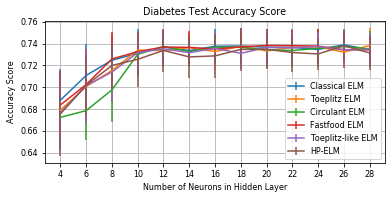

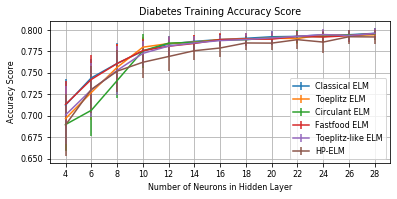

<Figure size 340.157x141.732 with 0 Axes>

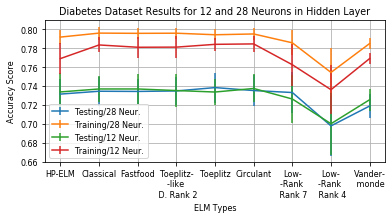

In [10]:
def getAllMeansAndStd(many_scores):
    means = []
    stds = []
    for scores in many_scores:
        (mean, std) = getMeansAndStd(scores)
        means.append(mean)
        stds.append(std)
    return (np.asarray(means), np.asarray(stds))

def getMeansAndStd(scores):
    scores = np.asarray(scores)
    mean = np.mean(scores, axis=-1)
    std = np.std(scores, axis=-1)
    return (mean, std)

start = 0
def plot_scores(scores, neurons, label, start=start, test=True):
    (mean, std) = getMeansAndStd(scores)
    plt.errorbar(neurons[start:], mean[start:, int(test)], std[start:, int(test)], label=label)

figure = plt.figure(figsize=(12/2.54, 5/2.54))
plt.rcParams.update({'font.size': 8})

plot_scores(classical_scores[:], neurons[:], "Classical ELM")

plot_scores(t_scores[:], neurons[:], "Toeplitz ELM")

plot_scores(c_scores[:], neurons[:], "Circulant ELM")

plot_scores(fastfood_scores[:], neurons[:], "Fastfood ELM")

plot_scores(low_rank[:], neurons[:], "Toeplitz-like ELM")

plot_scores(hpelm_scores[:], neurons[:], "HP-ELM")


plt.title("Diabetes Test Accuracy Score")
plt.xlabel("Number of Neurons in Hidden Layer")
plt.ylabel("Accuracy Score")

plt.xticks(neurons[start:])
plt.legend()
plt.grid(True)

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

plt.savefig("diabetes/diab_score_test.eps", format='eps', bbox_inches = 'tight',
    pad_inches = 0)

figure = plt.figure(figsize=(12/2.54, 5/2.54))
plt.rcParams.update({'font.size': 8})

plot_scores(classical_scores[:], neurons[:], "Classical ELM", test=False)

plot_scores(t_scores[:], neurons[:], "Toeplitz ELM", test=False)

plot_scores(c_scores[:], neurons[:], "Circulant ELM", test=False)

plot_scores(fastfood_scores[:], neurons[:], "Fastfood ELM", test=False)

plot_scores(low_rank[:], neurons[:], "Toeplitz-like ELM", test=False)

plot_scores(hpelm_scores[:], neurons[:], "HP-ELM", test=False)

plt.title("Diabetes Training Accuracy Score")
plt.xlabel("Number of Neurons in Hidden Layer")
plt.ylabel("Accuracy Score")

plt.xticks(neurons[start:])
plt.legend()
plt.grid(True)

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

plt.savefig("diabetes/diab_score_train.eps", format='eps', bbox_inches = 'tight',
    pad_inches = 0)

figure = plt.figure(figsize=(12/2.54, 5/2.54))
plt.rcParams.update({'font.size': 8})

table = []
number = -1

results = [hpelm_scores[number], classical_scores[number], fastfood_scores[number], low_rank[number], 
           t_scores[number], c_scores[number], real_low_7, real_low_4, vandermonde]
names = ["HP-ELM", "Classical", "Fastfood", "Toeplitz-\n-like \n D. Rank 2",
             "Toeplitz", "Circulant","Low-\n-Rank \n Rank 7", "Low-\n-Rank \n Rank 4",  "Vander-\n monde"]
(means, stds) = getAllMeansAndStd(results)

for i in range(len(names)):
    table.append([names[i], means[i], stds[i]])

figure = plt.figure(figsize=(12/2.54, 5/2.54))
plt.rcParams.update({'font.size': 8})

plt.errorbar(names, means[:, 1], stds[:, 1], label="Testing/28 Neur.")
plt.errorbar(names, means[:, 0], stds[:, 0], label="Training/28 Neur.")

number = 4

results = [hpelm_scores[number], classical_scores[number], fastfood_scores[number], low_rank[number], 
           t_scores[number], c_scores[number], real_low_7_12, real_low_4_12, vandermonde_12]
(means, stds) = getAllMeansAndStd(results)

for i in range(len(names)):
    table.append([names[i], means[i], stds[i]])
    
plt.errorbar(names, means[:, 1], stds[:, 1], label="Testing/12 Neur.")
plt.errorbar(names, means[:, 0], stds[:, 0], label="Training/12 Neur.")
plt.title("Diabetes Dataset Results for 12 and 28 Neurons in Hidden Layer")
plt.ylabel("Accuracy Score")
plt.xlabel("ELM Types")
plt.grid(True)
plt.legend()  

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.savefig("diabetes/diab_score_28.eps", format='eps', bbox_inches = 'tight',
    pad_inches = 0)

In [11]:
table

[['HP-ELM', array([0.79177083, 0.73145833]), array([0.00778281, 0.01583744])],
 ['Classical',
  array([0.79597222, 0.73447917]),
  array([0.00677074, 0.01525571])],
 ['Fastfood',
  array([0.79572917, 0.73427083]),
  array([0.0055838 , 0.01335976])],
 ['Toeplitz-\n-like \n D. Rank 2',
  array([0.79586806, 0.73479167]),
  array([0.00601497, 0.01494492])],
 ['Toeplitz',
  array([0.79423611, 0.73833333]),
  array([0.00596616, 0.01595349])],
 ['Circulant',
  array([0.79506944, 0.73520833]),
  array([0.00682148, 0.01654775])],
 ['Low-\n-Rank \n Rank 7',
  array([0.78569444, 0.733125  ]),
  array([0.0132953 , 0.02126021])],
 ['Low-\n-Rank \n Rank 4',
  array([0.754375 , 0.6978125]),
  array([0.02562218, 0.03137977])],
 ['Vander-\n monde',
  array([0.78496528, 0.71885417]),
  array([0.00588242, 0.01277858])],
 ['HP-ELM', array([0.76902778, 0.73375   ]), array([0.01657585, 0.0198912 ])],
 ['Classical', array([0.7834375, 0.736875 ]), array([0.00793925, 0.01375   ])],
 ['Fastfood',
  array([0.781